# Plots for CPVT Patients on Beta Blockers

Also exports the tables into a csv for R to parse for Fisher's Exact Test in step 10

In [2]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config, get_engine

In [3]:

sns.set_style("ticks")

In [4]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_09"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [5]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)

In [6]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
df_cpvt_bb = df_cpvt[
    df_cpvt["treatment_taken::Beta blocker"] == 1
    ].copy()

## Treatment Records (ANY)
 Num cpvt patients on any treatment

In [8]:
treatment_cols: list[str] = [
    col for col in df_cpvt.columns if col.startswith("treatment_taken::")
]
treatment_cols

['treatment_taken::Beta blocker',
 'treatment_taken::Catheter ablation',
 'treatment_taken::Enalapril',
 'treatment_taken::Flecainide',
 'treatment_taken::Implantable cardioverter-defibrillator',
 'treatment_taken::Left cardiac sympathetic denervation',
 'treatment_taken::Verapamil']

In [9]:
patient_ids = set()

for col in treatment_cols:
    # Include all patients who have a record of treatment or not treatment
    df_treat = df_cpvt[df_cpvt[col].notna()]
    patient_ids.update(df_treat["individual_id"])

print(f"There are {len(patient_ids)} CPVT patients with a treatment recorded")

There are 601 CPVT patients with a treatment recorded


In [10]:
with get_engine() as engine:
    num_patients = pd.read_sql("""
    SELECT COUNT(DISTINCT patient_id) AS num_patients
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE tr.patient_id IN (
        SELECT individual_id
        FROM cpvt_patients_v
    ) AND
    tr.treatment_taken IS NOT NULL
    """, engine)

num_patients

,num_patients
0,601


In [11]:
print(
    f"Of the {len(patient_ids)} patients with any treatment record, "
    f"{len(df_cpvt_bb)} ({len(df_cpvt_bb) / len(patient_ids) * 100:.2f}%) "
    f"are on beta blockers")

Of the 601 patients with any treatment record, 432 (71.88%) are on beta blockers


## Beta Blocker + Pharmacological Treatment

In [12]:
pharm_treat = [
    'treatment_taken::Enalapril',
    'treatment_taken::Flecainide',
    'treatment_taken::Verapamil'
]

patients_pharm_bb = set()
for col in pharm_treat:
    df_bb_and_pharm = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_pharm_bb.update(df_bb_and_pharm["individual_id"])

len(patients_pharm_bb)

131

In [13]:
invasive_treat = [
    'treatment_taken::Catheter ablation',
    'treatment_taken::Implantable cardioverter-defibrillator',
    'treatment_taken::Left cardiac sympathetic denervation',
]

patients_invasive_bb = set()
for col in invasive_treat:
    df_bb_and_invasive = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_invasive_bb.update(df_bb_and_invasive["individual_id"])

len(patients_invasive_bb)

129

## Beta Blocker + Any other

In [14]:
# get number of patients on each treatment
treatments = {
    # "Beta blocker": "Beta blocker",
    "Catheter ablation": "Catheter\nablation",
    "Enalapril": "Enalapril",
    "Flecainide": "Flecainide",
    "Implantable cardioverter-defibrillator": "ICD",
    "Left cardiac sympathetic denervation": "Left cardiac\nsympathetic\ndenervation",
    "Verapamil": "Verapamil"
}

treatment_nums = []

for treatment, plt_name in treatments.items():
    treatment_nums.append({
        "treatment": plt_name,
        "num_patients": df_cpvt_bb[f"treatment_taken::{treatment}"].sum()
    })

treatment_nums = pd.DataFrame(treatment_nums)
treatment_nums = treatment_nums.sort_values(by="num_patients", ascending=False)

treatment_nums

,treatment,num_patients
2,Flecainide,117.0
3,ICD,115.0
5,Verapamil,27.0
4,Left cardiac\nsympathetic\ndenervation,22.0
0,Catheter\nablation,10.0
1,Enalapril,2.0


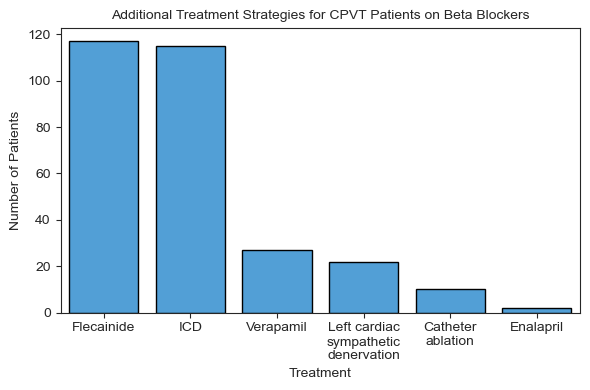

In [15]:
DEFAULT_COLOR = sns.color_palette("husl", 9)[6]
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=treatment_nums, x="treatment", y="num_patients",
                 color=DEFAULT_COLOR, edgecolor="black", )

plt.ylabel("Number of Patients")
plt.xlabel("Treatment")
plt.title("Additional Treatment Strategies for CPVT Patients on Beta Blockers",
          fontsize=10)

# add_bar_labels(ax, direction="horizontal")

plt.tight_layout()

save_current_plot("treatment_strategies_all_cpvt")

plt.show()

## Export Data for R

Export tables to do Fisher's Exact Test in R

ORIGINAL: 

R420Q
R420W
G357S
G3946S
S2246L
G2337V

In [16]:
TOP_N_VARIANTS = 5
# only get the top (N) variants by usage + S2246L (another known variant but want to see if it's significant)
SELECTED_VARIANT = "S2246L"

# only variants with more than 10 patients
variants_top_by_bb_usage = pd.DataFrame(df_cpvt_bb.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))
# rename (number of bb patients to Total (number of patients on bb)
variants_top_by_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_top_by_bb_usage.index.name = "p_hgvs_string"
variants_top_by_bb_usage = pd.concat(
    [
        variants_top_by_bb_usage.head(TOP_N_VARIANTS),
        variants_top_by_bb_usage[
            variants_top_by_bb_usage.index == SELECTED_VARIANT]
    ],
)

variants_top_by_bb_usage

,Total
p_hgvs_string,
G357S,94
R420Q,24
G2337V,21
R420W,17
M3978I,14
S2246L,9


In [17]:
def create_fisher_table(
        # the input dataframe
        input_df: pd.DataFrame,
        # what treatment to look at
        treatment_name: str,
        # should be a df with index with the protein HGVS names using AA1 format
        totals_df: pd.DataFrame,
        *,
        other_treatment: str = "beta_blocker",
        treatment_col_name: str = None
):
    treat_and_col_name = f"{treatment_col_name if treatment_col_name else treatment_name}_and_{other_treatment}"

    fish_table = pd.DataFrame(
        input_df[
            (input_df[f"treatment_taken::{treatment_name}"] == 1)
            &
            (input_df["p_hgvs_aa1"].isin(totals_df.index))
            ].groupby("p_hgvs_aa1")["individual_id"].count(),
    )
    fish_table.columns = [treat_and_col_name]

    fish_table = fish_table.join(
        totals_df, how="outer"
    )
    fish_table.fillna(0, inplace=True)
    fish_table[f"{other_treatment}_only"] = (
            fish_table["Total"] - fish_table[
        treat_and_col_name]
    )

    # rename index
    fish_table.index.name = "p_hgvs_string"
    # rearrange columns
    fish_table = fish_table[[
        treat_and_col_name,
        f"{other_treatment}_only",
        "Total"
    ]]
    # set all to int
    fish_table = fish_table.astype(int)

    # remove index and sort by total
    fish_table.reset_index(inplace=True)
    fish_table = fish_table.sort_values(by="Total", ascending=False)

    return fish_table

In [18]:
# get the total number taking flecainide + beta blockers, beta blockers only, total in F + BB
for treatment, fish_name in {
    "Flecainide": "Flecainide",
    "Implantable cardioverter-defibrillator": "ICD",
}.items():
    treatment_and_bb = create_fisher_table(
        df_cpvt_bb,
        treatment,
        variants_top_by_bb_usage,
        treatment_col_name=fish_name
    )

    display(treatment_and_bb)

    treatment_and_bb.to_csv(
        os.path.join(figures_dir / f"cpvt_{fish_name}_bb.csv"),
        index=False
    )

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
1,G357S,0,94,94
3,R420Q,2,22,24
0,G2337V,0,21,21
4,R420W,12,5,17
2,M3978I,9,5,14
5,S2246L,3,6,9


,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total
1,G357S,1,93,94
3,R420Q,13,11,24
0,G2337V,1,20,21
4,R420W,5,12,17
2,M3978I,6,8,14
5,S2246L,7,2,9


## After Flecainide Reccomended by HRS

HRS/EHRA/APHRS Expert Consensus Statement on the Diagnosis and Management of Patients with Inherited Primary Arrhythmia Syndromes: Document endorsed by HRS, EHRA, and APHRS in May 2013 and by ACCF, AHA, PACES, and AEPC in June 2013. https://doi.org/10.1016/j.hrthm.2013.05.014

In [19]:
after_2013 = df_cpvt_bb[df_cpvt_bb["year"] >= 2013]
before_2013 = df_cpvt_bb[df_cpvt_bb["year"] < 2013]

variants_after_2013_by_bb_usage = pd.DataFrame(after_2013.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))

# rename (number of bb patients to Total (number of patients on bb)
variants_after_2013_by_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_after_2013_by_bb_usage.index.name = "p_hgvs_string"
variants_after_2013_by_bb_usage = pd.concat(
    [
        variants_after_2013_by_bb_usage.head(TOP_N_VARIANTS),
        variants_after_2013_by_bb_usage[
            variants_after_2013_by_bb_usage.index == SELECTED_VARIANT]
    ],
)

variants_after_2013_by_bb_usage

,Total
p_hgvs_string,
G357S,91
G2337V,21
R420Q,15
R420W,9
C2277R,8
S2246L,4


In [20]:
f_and_bb_2013 = create_fisher_table(
    after_2013,
    "Flecainide",
    variants_after_2013_by_bb_usage,
)
f_and_bb_2013

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,91,91
1,G2337V,0,21,21
3,R420Q,1,14,15
4,R420W,7,2,9
0,C2277R,6,2,8
5,S2246L,3,1,4


In [21]:
f_and_bb_2013.to_csv(
    os.path.join(figures_dir / f"flecainide_fisher_2013_and_after.csv"),
    index=False
)

In [22]:
# Compare proportions of F+B before and after 2013
data_cmp = df_cpvt_bb.drop_duplicates("individual_id").copy()
data_cmp["before_2013"] = data_cmp["year"] < 2013
data_cmp = data_cmp.groupby("before_2013").agg(
    {
        "treatment_taken::Flecainide": "sum",
        "treatment_taken::Beta blocker": "sum"
    }
).rename(
    columns={
        "treatment_taken::Flecainide": "Flecainide_and_beta_blocker",
        "treatment_taken::Beta blocker": "Total"
    }
)
data_cmp["Beta_blocker_only"] = data_cmp["Total"] - data_cmp[
    "Flecainide_and_beta_blocker"]

data_cmp = data_cmp[
    ["Flecainide_and_beta_blocker", "Beta_blocker_only", "Total"]]

# rename index
data_cmp.index = ["2013 and after", "Before 2013"]
data_cmp.index.name = "Group"

data_cmp.head()

,Flecainide_and_beta_blocker,Beta_blocker_only,Total
Group,,,
2013 and after,80.0,239.0,319.0
Before 2013,37.0,76.0,113.0


In [23]:
# get number of publicatrions
data_cmp_pub = df_cpvt_bb.copy()
data_cmp_pub["before_2013"] = data_cmp_pub["year"] < 2013
data_cmp_pub = data_cmp_pub[data_cmp_pub["treatment_taken::Flecainide"] == True]

data_cmp_pub = data_cmp_pub.groupby("before_2013").agg(
    {
        "publication_id": "nunique",
        "individual_id": "nunique"
    }
).rename(
    columns={
        "publication_id": "num_publications",
        "individual_id": "num_individuals"
    }
)
data_cmp_pub

,num_publications,num_individuals
before_2013,,
False,36,80
True,6,37


## Plot Percentages

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total,Flecainide,total_pct
2,G357S,0,91,91,0.000000,100
1,G2337V,0,21,21,0.000000,100
3,R420Q,1,14,15,6.666667,100
4,R420W,7,2,9,77.777778,100
0,C2277R,6,2,8,75.000000,100
5,S2246L,3,1,4,75.000000,100


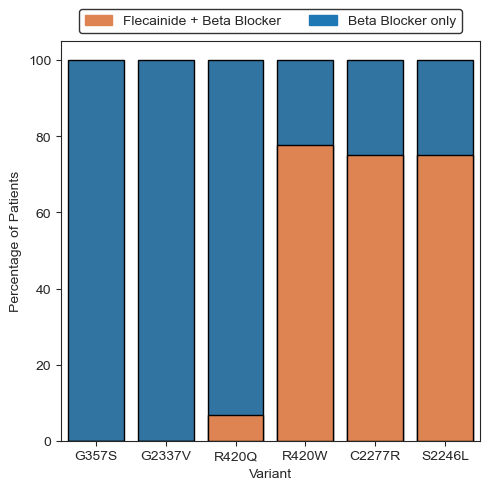

In [29]:
import matplotlib.patches as mpatches

sns.set_style("ticks")

# set the figure size
plt.figure(figsize=(5, 5))

# from raw value to percentage
f_and_bb_2013_pct = f_and_bb_2013.copy()
f_and_bb_2013_pct["Flecainide"] = (
        f_and_bb_2013["Flecainide_and_beta_blocker"] /
        f_and_bb_2013["Total"] * 100)

f_and_bb_2013_pct["total_pct"] = 100

display(f_and_bb_2013_pct)

sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette('deep')[1]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="p_hgvs_string", y="total_pct", data=f_and_bb_2013_pct,
                   color=sns_blue, edgecolor="black")

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="p_hgvs_string", y="Flecainide",
                   data=f_and_bb_2013_pct, facecolor=sns_orange,
                   edgecolor="black")

# add legend
top_bar = mpatches.Patch(color=sns_orange, label='Flecainide + Beta Blocker', )
bottom_bar = mpatches.Patch(color=sns_blue, label='Beta Blocker only')
plt.legend(handles=[top_bar, bottom_bar], loc="center",
           bbox_to_anchor=(0.5, 1.05), ncol=2, edgecolor="black")

plt.xlabel("Variant")
plt.ylabel("Percentage of Patients")
plt.tight_layout()

save_current_plot("flecainide_bb_percentages")

# show the graph
plt.show()

In [27]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)